## Project Overview: Garment Employee Productivity Prediction

In this project, we analyze a real-world dataset from the **garment manufacturing industry** to predict the productivity of employee teams. This dataset, sourced from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/), reflects the labor-intensive nature of the industry and the importance of forecasting productivity for operational efficiency.

We'll approach the problem as a **classification task** by transforming the continuous productivity scores (ranging from 0 to 1) into categorical labels. Our main goal is to build a **Decision Tree classifier** to predict productivity classes and evaluate its performance.

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

In [40]:
df = pd.read_csv("garments_worker_productivity.csv")

In [42]:
df.head()

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382


In [44]:
df.shape

(1197, 15)

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1197 non-null   object 
 1   quarter                1197 non-null   object 
 2   department             1197 non-null   object 
 3   day                    1197 non-null   object 
 4   team                   1197 non-null   int64  
 5   targeted_productivity  1197 non-null   float64
 6   smv                    1197 non-null   float64
 7   wip                    691 non-null    float64
 8   over_time              1197 non-null   int64  
 9   incentive              1197 non-null   int64  
 10  idle_time              1197 non-null   float64
 11  idle_men               1197 non-null   int64  
 12  no_of_style_change     1197 non-null   int64  
 13  no_of_workers          1197 non-null   float64
 14  actual_productivity    1197 non-null   float64
dtypes: f

## Dataset Description and Overview

This dataset captures daily production data from a garment manufacturing environment. It contains **1,197 rows** and **15 columns**, covering operational, workforce, and performance-related information. Below is a brief description of each column:

- **date**: Date of observation in MM-DD-YYYY format.  
- **quarter**: A portion of the month (each month divided into four quarters).  
- **department**: Department responsible for the observation.  
- **day**: Day of the week.  
- **team**: Team number associated with the instance.  
- **targeted_productivity**: Target productivity set by management for the team.  
- **smv**: Standard Minute Value — the time allocated to complete a task.  
- **wip**: Work in Progress — unfinished product items (contains missing values).  
- **over_time**: Overtime in minutes.  
- **incentive**: Financial incentive provided in BDT.  
- **idle_time**: Time when production was interrupted.  
- **idle_men**: Number of workers idle during production interruption.  
- **no_of_style_change**: Number of times product style was changed.  
- **no_of_workers**: Total number of workers in the team.  
- **actual_productivity**: Actual productivity achieved (target variable, between 0 and 1).

### Data Types and Missing Values

- Most columns are numeric (`float64` or `int64`), while `date`, `quarter`, `department`, and `day` are categorical (`object`).
- The `wip` column has substantial missing data (only 691 non-null values).

### Dataset Cleaning (I)

In [50]:
df['date'] = pd.to_datetime(df['date'])

In [52]:
df["department"].value_counts()

department
sweing        691
finishing     257
finishing     249
Name: count, dtype: int64

In [54]:
df['department'] = df['department'].str.strip().str.lower()

df["department"].value_counts()

department
sweing       691
finishing    506
Name: count, dtype: int64

Upon examining the value counts for the **`department`** column, we found a data quality issue. Specifically, the same department label `"finishing"` appeared twice with slightly different values, due to inconsistent formatting of trailing whitespace.

This can result in misleading groupings and inaccurate analysis or model training. To fix this, we standardize the department names by stripping whitespace and converting all entries to lowercase or title case.

In [57]:
actual_greater_target = len(df[df["actual_productivity"] > df["targeted_productivity"]]) / len(df)
actual_eqaul_target = len(df[df["actual_productivity"] == df["targeted_productivity"]]) / len(df)
actual_lesser_target = len(df[df["actual_productivity"] < df["targeted_productivity"]]) / len(df)

print(f"""
Proportion of observations where:
- Actual productivity > Targeted productivity: {actual_greater_target:.2%}
- Actual productivity = Targeted productivity: {actual_eqaul_target:.2%}
- Actual productivity < Targeted productivity: {actual_lesser_target:.2%}
""")


Proportion of observations where:
- Actual productivity > Targeted productivity: 72.60%
- Actual productivity = Targeted productivity: 0.50%
- Actual productivity < Targeted productivity: 26.90%



In [59]:
print(len(df[df["actual_productivity"] > 1]))

37


In [61]:
df[df["actual_productivity"] > 1]

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
337,2015-01-20,Quarter3,finishing,Tuesday,5,0.70,4.15,NaN,1440,0,0.0,0,0,8.0,1.033570
437,2015-01-26,Quarter4,finishing,Monday,3,0.75,3.94,NaN,1800,0,0.0,0,0,10.0,1.059621
456,2015-01-27,Quarter4,sweing,Tuesday,2,0.75,22.52,1635.0,6840,119,0.0,0,0,57.0,1.000230
457,2015-01-27,Quarter4,sweing,Tuesday,3,0.75,22.52,1299.0,6840,119,0.0,0,0,57.0,1.000230
477,2015-01-28,Quarter4,sweing,Wednesday,2,0.80,22.52,1559.0,6840,90,0.0,0,0,57.0,1.000230
478,2015-01-28,Quarter4,sweing,Wednesday,3,0.80,22.52,1350.0,6840,113,0.0,0,0,57.0,1.000230
498,2015-01-29,Quarter5,sweing,Thursday,2,0.80,22.52,1416.0,6840,113,0.0,0,0,57.0,1.000230
518,2015-01-31,Quarter5,sweing,Saturday,3,0.80,22.52,1136.0,6960,113,0.0,0,0,58.0,1.000457
519,2015-01-31,Quarter5,sweing,Saturday,2,0.80,22.52,1397.0,6840,113,0.0,0,0,57.0,1.000230
542,2015-02-01,Quarter1,finishing,Sunday,8,0.65,4.15,NaN,960,0,0.0,0,0,8.0,1.011562


The **`actual_productivity`** column represents productivity as a fraction (or percentage), and therefore its maximum value should be 1. However, upon inspection, we found that some rows contain values greater than 1, which is not valid.

These could be due to data entry errors or anomalies. To ensure data integrity and improve model performance, we removed rows where `actual_productivity` > 1.

In [64]:
df[df["wip"].notnull()]

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,2015-01-01,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
2,2015-01-01,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,2015-01-01,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,2015-01-01,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382
5,2015-01-01,Quarter1,sweing,Thursday,7,0.80,25.90,984.0,6720,38,0.0,0,0,56.0,0.800125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187,2015-03-11,Quarter2,sweing,Wednesday,4,0.75,26.82,1054.0,7080,45,0.0,0,0,59.0,0.750051
1188,2015-03-11,Quarter2,sweing,Wednesday,5,0.70,26.82,992.0,6960,30,0.0,0,1,58.0,0.700557
1189,2015-03-11,Quarter2,sweing,Wednesday,8,0.70,30.48,914.0,6840,30,0.0,0,1,57.0,0.700505
1190,2015-03-11,Quarter2,sweing,Wednesday,6,0.70,23.41,1128.0,4560,40,0.0,0,1,38.0,0.700246


In [66]:
df["wip"].isnull().sum()

506

In [70]:
df.drop(["wip"], axis=1)

,date,quarter,department,day,team,targeted_productivity,smv,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,2015-01-01,Quarter1,sweing,Thursday,8,0.80,26.16,7080,98,0.0,0,0,59.0,0.940725
1,2015-01-01,Quarter1,finishing,Thursday,1,0.75,3.94,960,0,0.0,0,0,8.0,0.886500
2,2015-01-01,Quarter1,sweing,Thursday,11,0.80,11.41,3660,50,0.0,0,0,30.5,0.800570
3,2015-01-01,Quarter1,sweing,Thursday,12,0.80,11.41,3660,50,0.0,0,0,30.5,0.800570
4,2015-01-01,Quarter1,sweing,Thursday,6,0.80,25.90,1920,50,0.0,0,0,56.0,0.800382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,2015-03-11,Quarter2,finishing,Wednesday,10,0.75,2.90,960,0,0.0,0,0,8.0,0.628333
1193,2015-03-11,Quarter2,finishing,Wednesday,8,0.70,3.90,960,0,0.0,0,0,8.0,0.625625
1194,2015-03-11,Quarter2,finishing,Wednesday,7,0.65,3.90,960,0,0.0,0,0,8.0,0.625625
1195,2015-03-11,Quarter2,finishing,Wednesday,9,0.75,2.90,1800,0,0.0,0,0,15.0,0.505889


The **`wip`** (Work in Progress) column contains **691 missing values**, which accounts for a significant portion of the dataset. This level of missing data can introduce noise and bias, especially in tree-based models that do not handle missing values gracefully without imputation.

Since the missing values are not randomly distributed and we lack sufficient context to impute them reliably, we choose to remove the `wip` column entirely from our modeling dataset. This helps avoid introducing inaccurate or misleading information int

In [73]:
df["quarter"].value_counts()

quarter
Quarter1    360
Quarter2    335
Quarter4    248
Quarter3    210
Quarter5     44
Name: count, dtype: int64

The **`quarter`** column should only have **Quarter1–Quarter4**, but **Quarter5** appears, indicating a data quality issue.  
We identify these rows and will verify dates to correct or reassign them, ensuring consistency in the dataset.

In [76]:
df[df["quarter"] == "Quarter5"]

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
498,2015-01-29,Quarter5,sweing,Thursday,2,0.80,22.52,1416.0,6840,113,0.0,0,0,57.0,1.000230
499,2015-01-29,Quarter5,finishing,Thursday,4,0.80,4.30,NaN,1200,0,0.0,0,0,10.0,0.989000
500,2015-01-29,Quarter5,sweing,Thursday,3,0.80,22.52,1287.0,6840,100,0.0,0,0,57.0,0.950186
501,2015-01-29,Quarter5,sweing,Thursday,4,0.80,22.52,1444.0,6900,88,0.0,0,0,57.5,0.900800
502,2015-01-29,Quarter5,sweing,Thursday,10,0.80,22.52,1088.0,6720,88,0.0,0,0,56.0,0.900130
503,2015-01-29,Quarter5,finishing,Thursday,6,0.50,2.90,NaN,1200,0,0.0,0,0,10.0,0.899000
504,2015-01-29,Quarter5,finishing,Thursday,8,0.65,4.15,NaN,960,0,0.0,0,0,8.0,0.877552
505,2015-01-29,Quarter5,finishing,Thursday,11,0.60,2.90,NaN,960,0,0.0,0,0,8.0,0.864583
506,2015-01-29,Quarter5,finishing,Thursday,10,0.80,3.94,NaN,1200,0,0.0,0,0,10.0,0.856950
507,2015-01-29,Quarter5,finishing,Thursday,1,0.75,3.94,NaN,1200,0,0.0,0,0,10.0,0.853667


The **`quarter`** column contained invalid **Quarter5** values.  
Since all associated dates are either the 29th or 31st, these entries were reassigned to **Quarter4** for consistency.

In [79]:
df.loc[df["quarter"] == "Quarter5", "quarter"] = "Quarter4"
df["quarter"].value_counts()

quarter
Quarter1    360
Quarter2    335
Quarter4    292
Quarter3    210
Name: count, dtype: int64

In [81]:
df.loc[df["quarter"] == "Quarter1", "quarter"] = 1
df.loc[df["quarter"] == "Quarter2", "quarter"] = 2
df.loc[df["quarter"] == "Quarter3", "quarter"] = 3
df.loc[df["quarter"] == "Quarter4", "quarter"] = 4

df["quarter"] = df["quarter"].astype(int)

df["quarter"].value_counts()

quarter
1    360
2    335
4    292
3    210
Name: count, dtype: int64

Renamed **`quarter`** values to keep only the numeric part (1–4) and converted the column to integers for easier analysis.

### Column Selection

To streamline the dataset and focus on the most relevant features for our analysis, we retained only columns related to time period, production context, workforce, and performance metrics.  
The final set of columns includes:  
- **quarter** – part of the month (adjusted and standardized)  
- **department** – production department  
- **day** – day of the week  
- **team** – production team identifier  
- **targeted_productivity** – planned productivity level  
- **smv** – standard minute value for tasks  
- **over_time** – overtime minutes worked  
- **incentive** – bonus payments  
- **no_of_workers** – number of workers  
- **actual_productivity** – achieved productivity level  
- **productive** – target label indicating whether the planned productivity was met


In [85]:
df = df[["quarter", "department", "day", "team", "targeted_productivity", "smv", "over_time", "incentive", "no_of_workers", "actual_productivity"]]

In [87]:
df.head()

,quarter,department,day,team,targeted_productivity,smv,over_time,incentive,no_of_workers,actual_productivity
0,1,sweing,Thursday,8,0.80,26.16,7080,98,59.0,0.940725
1,1,finishing,Thursday,1,0.75,3.94,960,0,8.0,0.886500
2,1,sweing,Thursday,11,0.80,11.41,3660,50,30.5,0.800570
3,1,sweing,Thursday,12,0.80,11.41,3660,50,30.5,0.800570
4,1,sweing,Thursday,6,0.80,25.90,1920,50,56.0,0.800382


In [89]:
df["productive"] = df.apply(
    lambda row: True if row["actual_productivity"] >= row["targeted_productivity"] else False,
    axis=1
)

In [91]:
df.head()

,quarter,department,day,team,targeted_productivity,smv,over_time,incentive,no_of_workers,actual_productivity,productive
0,1,sweing,Thursday,8,0.80,26.16,7080,98,59.0,0.940725,True
1,1,finishing,Thursday,1,0.75,3.94,960,0,8.0,0.886500,True
2,1,sweing,Thursday,11,0.80,11.41,3660,50,30.5,0.800570,True
3,1,sweing,Thursday,12,0.80,11.41,3660,50,30.5,0.800570,True
4,1,sweing,Thursday,6,0.80,25.90,1920,50,56.0,0.800382,True


A new boolean column **productive** was created to indicate whether the targeted productivity level was achieved.  
It checks if `targeted_productivity` is greater than `actual_productivity` and assigns:
- **True** if the target was met or exceeded
- **False** otherwise

### Dataset Cleaning (II)

In the second phase of data cleaning, all non-numerical columns were transformed into numerical format to ensure compatibility with scikit-learn, which requires numerical inputs for model training.

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   quarter                1197 non-null   int64  
 1   department             1197 non-null   object 
 2   day                    1197 non-null   object 
 3   team                   1197 non-null   int64  
 4   targeted_productivity  1197 non-null   float64
 5   smv                    1197 non-null   float64
 6   over_time              1197 non-null   int64  
 7   incentive              1197 non-null   int64  
 8   no_of_workers          1197 non-null   float64
 9   actual_productivity    1197 non-null   float64
 10  productive             1197 non-null   bool   
dtypes: bool(1), float64(4), int64(4), object(2)
memory usage: 94.8+ KB


In [97]:
pd.set_option('future.no_silent_downcasting', True)
df["department"] = df["department"].replace({"finishing": 0, "sweing": 1})
df.rename(columns={"department": "dept_sweing"}, inplace=True)

In [99]:
df = pd.concat([df, pd.get_dummies(df["quarter"], prefix = "q", dtype=int)], axis = 1).drop(["quarter"], axis = 1)

In [101]:
df = pd.concat([df, pd.get_dummies(df["day"], prefix= None)], axis=1).drop(["day"], axis=1)

In [103]:
df = pd.concat([df, pd.get_dummies(df["team"], prefix= "team")], axis=1).drop(["team"], axis=1)

In [105]:
df.head()

,dept_sweing,targeted_productivity,smv,over_time,incentive,no_of_workers,actual_productivity,productive,q_1,q_2,...,team_3,team_4,team_5,team_6,team_7,team_8,team_9,team_10,team_11,team_12
0,1,0.80,26.16,7080,98,59.0,0.940725,True,1,0,...,False,False,False,False,False,True,False,False,False,False
1,0,0.75,3.94,960,0,8.0,0.886500,True,1,0,...,False,False,False,False,False,False,False,False,False,False
2,1,0.80,11.41,3660,50,30.5,0.800570,True,1,0,...,False,False,False,False,False,False,False,False,True,False
3,1,0.80,11.41,3660,50,30.5,0.800570,True,1,0,...,False,False,False,False,False,False,False,False,False,True
4,1,0.80,25.90,1920,50,56.0,0.800382,True,1,0,...,False,False,False,True,False,False,False,False,False,False


### Building the Decision Tree

Now that the data has been properly prepared for use in scikit-learn, we can proceed to building our Decision Tree model.

In [108]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

X = df.drop(["productive"], axis=1)
y = df["productive"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

classifier = DecisionTreeClassifier(max_depth=3, random_state=42)
classifier.fit(X_train, y_train)

y_predicted = classifier.predict(X_test)

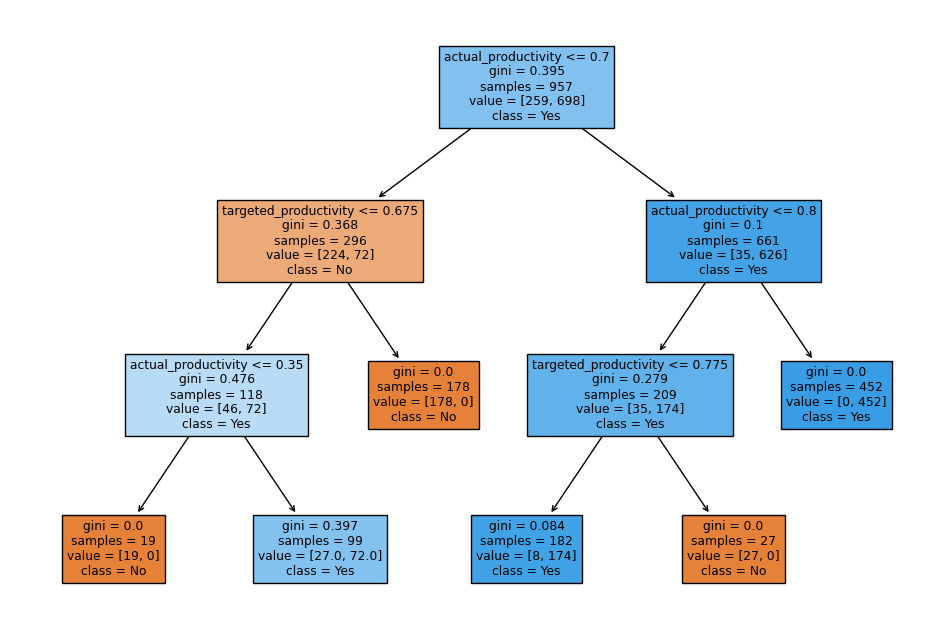

In [116]:
plt.figure(figsize=(12, 8))
plot_tree(classifier, filled=True, feature_names=X.columns, class_names=["No", "Yes"])
plt.savefig("tree.jpg")
plt.show()

In [122]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_predicted)
precision = precision_score(y_test, y_predicted, average="binary")  
recall = recall_score(y_test, y_predicted, average="binary")
f1 = f1_score(y_test, y_predicted, average="binary")

print(f"Accuracy: {accuracy:.2%}")
print(f"Precision: {precision:.2%}")
print(f"Recall: {recall:.2%}")
print(f"F1 Score: {f1:.2%}")

Accuracy: 97.08%
Precision: 96.70%
Recall: 99.44%
F1 Score: 98.05%


### Understanding the Decision Tree

A decision tree is a simple, visual way to understand how our data is used to make predictions. Imagine it as a series of **"yes or no" questions**, starting from the top and moving down through the branches until you reach a final decision at the bottom.  

Each question looks at one piece of information—such as *hours worked* or *number of tasks completed*—to help decide the outcome.

---

**Example:**  
The first question in our tree might ask:  

> *Is the employee’s actual productivity less than the target productivity?*  

- **Yes** → The path moves down one branch.  
- **No** → It moves down a different branch.  

This process continues until we reach a **leaf**, which tells us the predicted classification—whether performance is **On Target** or **Below Target**.

---

From our tree visualization, we can see **which factors matter most**.  
Questions closer to the top are more important because they split the data early and guide most decisions.  

This helps us identify the **key drivers** of employee performance, so we know where to focus our attention for improvements.

---

By following these branches, we not only predict performance but also understand *why* the prediction is made.  

This transparency means leaders can trust the model and make informed decisions—whether that’s:  
- Adjusting workloads  
- Offering extra training  
- Rewarding top performers


### Building Random Forest

Now that the decision tree model has provided us with valuable insights, we can take the next step and explore whether its predictive performance can be improved. To do this, we’ll build a Random Forest classifier — an ensemble learning method that combines multiple decision trees to produce more robust and accurate predictions. By leveraging the power of multiple models working together, we aim to reduce overfitting, capture more complex patterns in the data, and potentially achieve better results than with a single decision tree.

In [132]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_precision = precision_score(y_test, y_pred_rf, average="binary")  
rf_recall = recall_score(y_test, y_pred_rf, average="binary")
rf_f1 = f1_score(y_test, y_pred_rf, average="binary")

print(f"Random Forest Accuracy: {rf_accuracy:.2%}")
print(f"Random Forest Precision: {rf_precision:.2%}")
print(f"Random Forest Recall: {rf_recall:.2%}")
print(f"Random Forest F1 Score: {rf_f1:.2%}")

Random Forest Accuracy: 97.50%
Random Forest Precision: 97.24%
Random Forest Recall: 99.44%
Random Forest F1 Score: 98.32%


## Random Forest Model Performance

The Random Forest classifier significantly improved prediction performance with the following metrics on the test set:

- **Accuracy:** 97.50%  
- **Precision:** 97.24%  
- **Recall:** 99.44%  
- **F1 Score:** 98.32%  

These results indicate a highly accurate and balanced model, especially excelling at correctly identifying positive cases (high recall).
